# Evaluating Imputation Against Ground Truth Fold Change

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns

from pyproteonet.simulation import molecule_set_from_degree_distribution, simulate_protein_peptide_dataset, simulate_mcars, simulate_mnars_thresholding
from pyproteonet.aggregation import maxlfq
from pyproteonet.processing import logarithmize

## Simulating a Dataset

In [2]:
# We define some degree distributions roughly assembling those of a real world dataset
protein_deg_distribution = [0, 0.1445, 0.1221, 0.1151, 0.0933, 0.0692, 0.0655, 0.0508, 0.0472, 0.0362, 0.0311, 0.0277, 0.0209, 0.0199, 0.0163, 0.0143,
                            0.012, 0.0105, 0.0093, 0.0087, 0.0081, 0.0063, 0.0063, 0.0055, 0.0054, 0.0043, 0.0043, 0.0042, 0.0039, 0.0037, 0.0034,
                            0.0031, 0.0022, 0.0021, 0.0019, 0.0019, 0.0019, 0.0015, 0.0012, 0.001, 0.001]
peptide_deg_distribution = [0, 0.9591, 0.0341, 0.0046, 0.0014]

First, we create a set of proteins with related peptides.
Next, we simulate abundance values for those peptides.
During the simulation we also simulate a fold change of 30% of all proteins.
This is done by simulating a single condition group affecting 30% of all proteins inthe last five samples. 

In [41]:
# We aim for a simulated dataset with 100 proteins and 10 samples
num_proteins = 100
num_samples = 10

# We use a simple heuristic to determine the number of peptides for the given number of proteins while still closely matching the degree distributions
protein_degs = np.round(num_proteins * np.array(protein_deg_distribution))
prot_edges = np.sum(np.arange(len(protein_deg_distribution)) * protein_degs)
num_peptides = 1
pep_edges = 0
while pep_edges < prot_edges:
    num_peptides += 1
    peptide_degs = np.round(num_peptides * np.array(peptide_deg_distribution))
    pep_edges = np.sum(np.arange(len(peptide_deg_distribution)) * peptide_degs)
if pep_edges > prot_edges:
    diff = pep_edges - prot_edges
    for i in range(len(peptide_degs)-1, -1, -1):
        if peptide_degs[i] > 0 and i <= diff:
            peptide_degs[i] -= 1
            diff -= i
        if diff == 0:
            break

# Create a protein peptide molecule set for the given number of proteins/peptides and degree distribution
ms = molecule_set_from_degree_distribution(molecule1_name='protein', molecule2_name='peptide', mapping_name='peptide-protein',
                                           molecule1_degree_distribution=protein_degs, molecule2_degree_distribution=peptide_degs)
# Lets simulate some abundance values for the given molecule set
condition_proteins = ms.molecules['protein'].sample(frac=0.3).index
ds = simulate_protein_peptide_dataset(molecule_set=ms, mapping='peptide-protein', samples=num_samples,
                                      log_abundance_mu=15.9, log_abundance_sigma=1.8,
                                      log_protein_error_sigma=0.3, peptide_noise_sigma= 115005.3,
                                      flyability_alpha=0.7, flyability_beta=2.1, simulate_flyability=True,
                                      condition_samples=[[f'sample{s}' for s in (range(5,10))]], condition_affected=[condition_proteins],
                                      log2_condition_means=[2.0], log2_condition_stds=[0.66])

Finally, we incorporate some missing values (MNARs and MCARs)

In [42]:
simulate_mnars_thresholding(dataset=ds, thresh_mu=115005.3 / 2, thresh_sigma=115005.3 / 4, molecule='peptide', column='abundance',
                            result_column='abundance_missing', mask_column='is_mnar', inplace=True)
simulate_mcars(dataset=ds, amount=0.3, molecule='peptide', column='abundance', result_column='abundance_missing', mask_column='is_mcar', inplace=True)

In [43]:
df = ds.values['peptide'].df
df.is_mnar.sum() / df.shape[0], df.is_mcar.sum() / df.shape[0]

(0.025, 0.2996688741721854)

In the end all abundance/aggregated values are logarithmized as it is commonly done in proteomics because logarithmized values are more normally distributed.

In [44]:
ds = logarithmize(data=ds, columns=['abundance', 'abundance_gt', 'abundance_missing'])

## MaxLFQ aggregation

In [45]:
ds.values['protein']['aggregated'] = maxlfq(dataset=ds, molecule='protein', mapping='peptide-protein', partner_column='abundance_missing',
                                            min_ratios=2, median_fallback=False, is_log=True)

Now the 'aggregated' value column holds the aggregated values and the 'abundance_gt' value column which was written during the simulation
holds the ground truth values

In [46]:
ds.values['protein'].df

abundance_gt  aggregated
sample  id                          
sample0 0      17.169365         NaN
        1      20.560688         NaN
        2      15.000974         NaN
        3      14.404043         NaN
        4      15.042509         NaN
...                  ...         ...
sample9 92     16.595688   15.078889
        93     18.847798   17.029333
        94     19.827979   17.730384
        95     13.603674   12.169696
        96     17.982749   16.312612

[970 rows x 2 columns]

Plotting the aggregated abundance ratios we see two clusters corresponding to the proteins affected by the condition and the unaffected ones. 

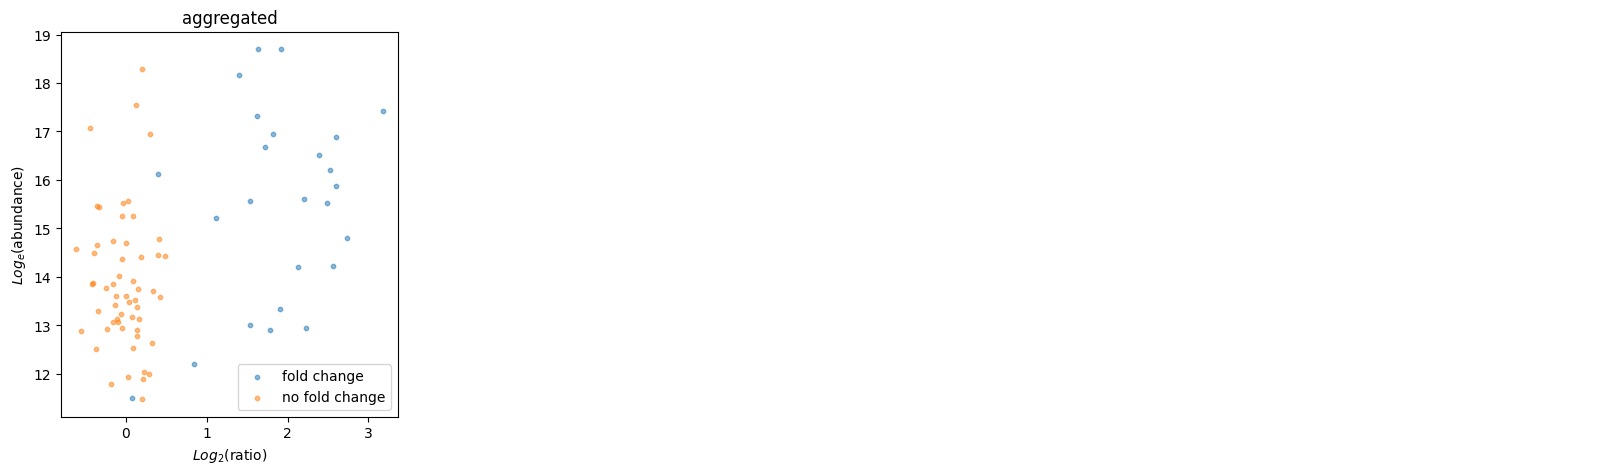

In [48]:
from pyproteonet.visualization import plot_ratio_scatter

categories = pd.Series(data='no fold change', index=ds.molecules['protein'].index)
categories[condition_proteins] = 'fold change'
a,b = plot_ratio_scatter(dataset=ds, molecule='protein', columns=['aggregated'],
                         numerator_samples=[f'sample{s}' for s in (range(5,10))], denominator_samples=[f'sample{s}' for s in (range(5))],
                         plot_density=False, is_log=True, alpha=0.5, categories=categories)

## Missing Value Imputation

Pyproteonet provides a wide range of established imputation functions combining both native python implementation and wrappers around R packages for imputation functions where no Python implementation is available yet. 

Here we use the high level api to impute on both protein and peptide level using a bunch of different imputation functions.

R[write to console]: Loading required package: tmvtnorm

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: gmm

R[write to console]: Loading required package: sandwich

R[write to console]: Loading required package: norm

R[write to console]: This package has some major limitations
(for example, it does not work reliably when
the number of variables exceeds 30),
and has been superseded by the norm2 package.

R[write to console]: Loading required package: pcaMethods

R[write to console]: Loading required package: Biobase

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    any

  0%|          | 0/7 [00:00<?, ?it/s]

minprob minprob
[1] 0.3002219
mindet mindet
bpca bpca
missforest missforest
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
knn knn
isvd isvd
[IterativeSVD] Iter 1: observed MAE=1.029508
[IterativeSVD] Iter 2: observed MAE=0.361089
[IterativeSVD] Iter 3: observed MAE=0.277206
[IterativeSVD] Iter 4: observed MAE=0.251593
[IterativeSVD] Iter 5: observed MAE=0.239997
[IterativeSVD] Iter 6: observed MAE=0.233418
[IterativeSVD] Iter 7: observed MAE=0.228806
[IterativeSVD] Iter 8: observed MAE=0.225354
[IterativeSVD] Iter 9: observed MAE=0.222133
[IterativeSVD] Iter 10: observed MAE=0.219068
[IterativeSVD] Iter 11: observed MAE=0.216221
[IterativeSVD] Iter 12: observed MAE=0.213613
[IterativeSVD] Iter 13: observed MAE=0.211435
[IterativeSVD] Iter 14: observed MAE=0.209869
[IterativeSVD] Iter 15: observed MAE=0.208677
[IterativeSVD] Iter 16: observed MAE=0.207568
[IterativeSVD] Iter 17: observed MAE=0.206538
[It

epoch,train_loss,valid_loss,time
0,771.526489,92.160431,00:00
1,772.366943,92.353256,00:00
2,769.833069,92.375992,00:00
3,768.604248,92.269379,00:00
4,758.263245,91.880707,00:00
5,747.080200,91.415390,00:00
6,728.280090,90.840988,00:00
7,712.120911,90.002388,00:00
8,691.932617,88.560638,00:00
9,668.623352,86.934418,00:00


  0%|          | 0/7 [00:00<?, ?it/s]

minprob minprob
[1] 0.3743327
mindet mindet
bpca bpca
missforest missforest
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
knn knn
isvd isvd
[IterativeSVD] Iter 1: observed MAE=3.794830
[IterativeSVD] Iter 2: observed MAE=1.191989
[IterativeSVD] Iter 3: observed MAE=0.644522
[IterativeSVD] Iter 4: observed MAE=0.479546
[IterativeSVD] Iter 5: observed MAE=0.414731
[IterativeSVD] Iter 6: observed MAE=0.382314
[IterativeSVD] Iter 7: observed MAE=0.361593
[IterativeSVD] Iter 8: observed MAE=0.345830
[IterativeSVD] Iter 9: observed MAE=0.332967
[IterativeSVD] Iter 10: observed MAE=0.321903
[IterativeSVD] Iter 11: observed MAE=0.313058
[IterativeSVD] Iter 12: observed MAE=0.305612
[IterativeSVD] Iter 13: observed MAE=0.298658
[IterativeSVD] Iter 14: observed MAE=0.291231
[IterativeSVD] Iter 15: observed MAE=0.281993
[IterativeSVD] Iter 16: observed MAE=0.270293
[IterativeSVD] Iter 17: observed MAE=0.257632
[IterativeSVD] Iter 18: obser

epoch,train_loss,valid_loss,time
0,4583.745117,426.797913,00:00
1,4558.276367,426.060699,00:00
2,4545.520020,424.628357,00:00
3,4505.635742,422.432526,00:00
4,4463.166016,419.978271,00:00
5,4402.731445,417.171478,00:00
6,4331.463379,413.485657,00:00
7,4241.655273,409.318634,00:00
8,4149.645020,403.610596,00:00
9,4035.374268,396.451233,00:00


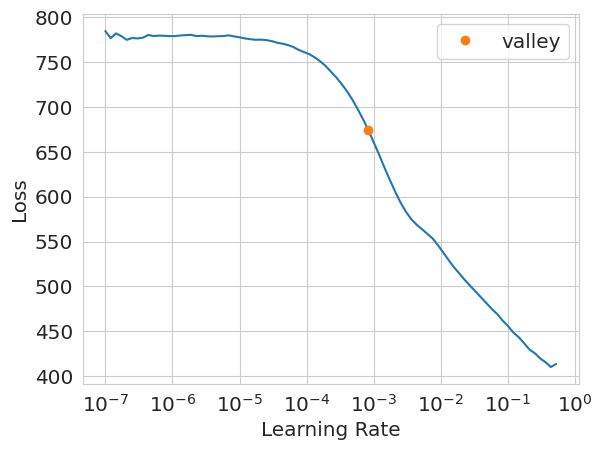

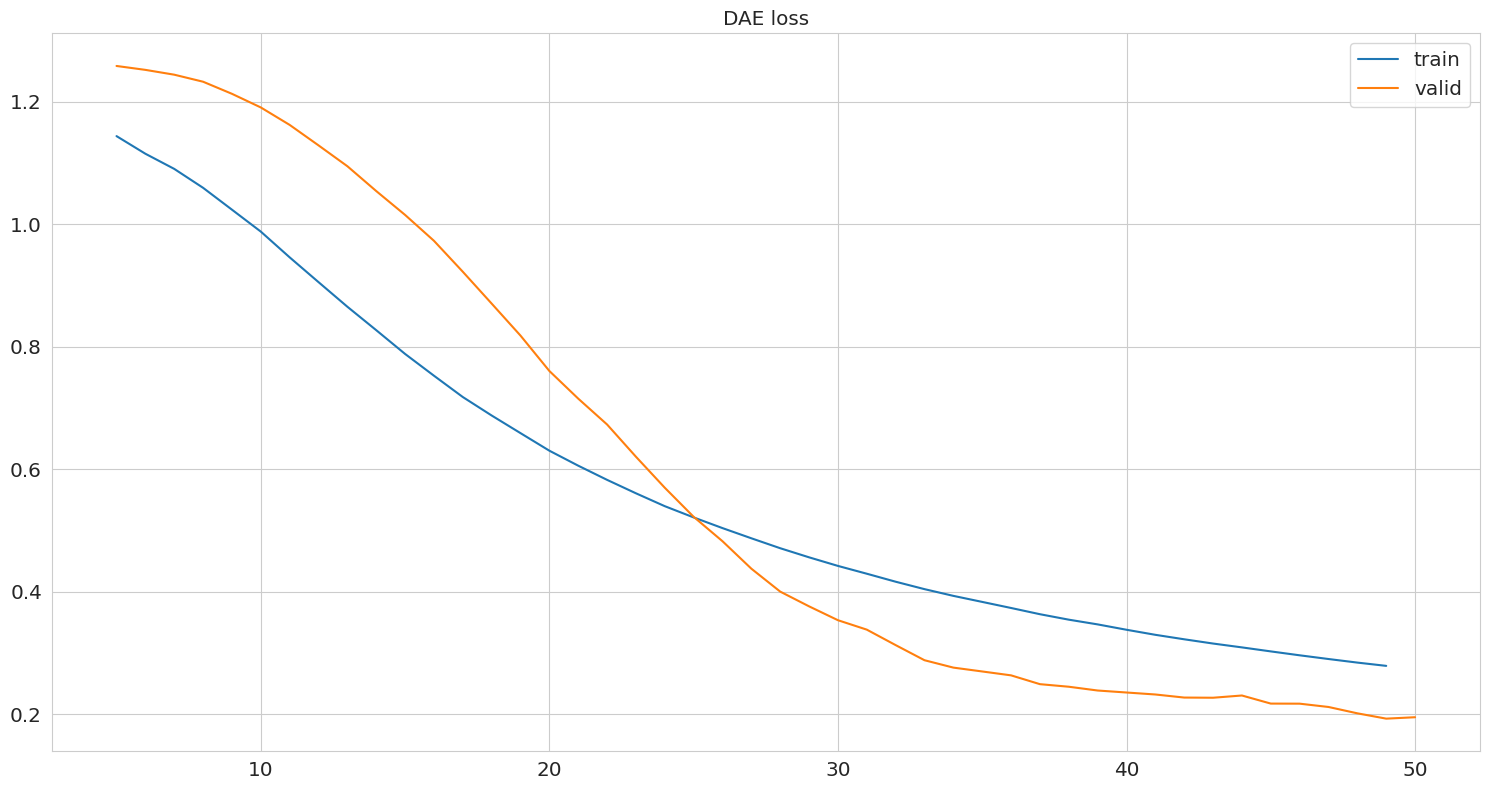

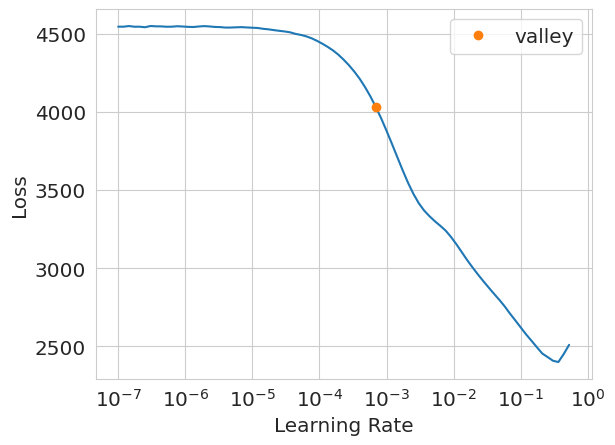

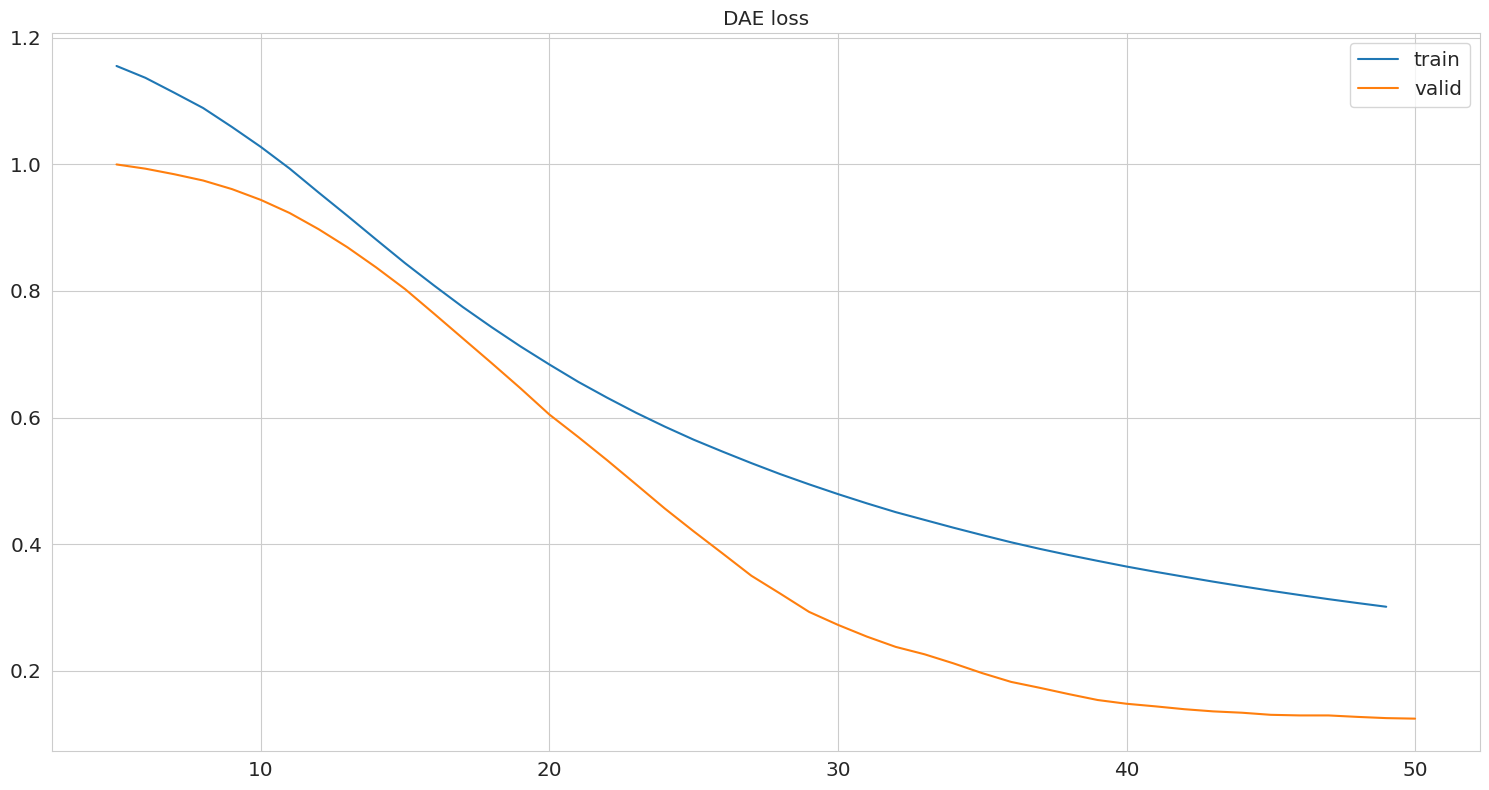

In [49]:
from pyproteonet.imputation import impute_molecule

imputation_methods = ["minprob", "mindet", "bpca", "missforest", "knn", "isvd", "dae"]

impute_molecule(dataset=ds, molecule='protein', column='aggregated', methods=imputation_methods)
impute_molecule(dataset=ds, molecule='peptide', column='abundance_missing', methods=imputation_methods)

Looking at the result we can see that the missing values are gone:

In [50]:
ds.values['peptide'].df

abundance  abundance_gt  abundance_missing  is_mnar  is_mcar  \
sample  id                                                                  
sample0 0       15.651        17.169                NaN    False     True   
        1       20.386        20.561             20.386    False    False   
        2       14.708        15.001             14.708    False    False   
        3       14.319        14.404             14.319    False    False   
        4       12.920        15.043             12.920    False    False   
...                ...           ...                ...      ...      ...   
sample9 599     14.434        18.261             14.434    False    False   
        600     16.882        19.213                NaN    False     True   
        601     16.952        19.500                NaN    False     True   
        602     14.137        18.043             14.137    False    False   
        603     17.885        18.359             17.885    False    False   

             minprob  mindet   bpca  missforest    knn   isvd    dae  
sample  id                                                            
sample0 0     11.000  10.565 16.101      16.062 16.047 16.135 15.313  
        1     20.386  20.386 20.386      20.386 20.386 20.386 20.386  
        2     14.708  14.708 14.708      14.708 14.708 14.708 14.708  
        3     14.319  14.319 14.319      14.319 14.319 14.319 14.319  
        4     12.920  12.920 12.920      12.920 12.920 12.920 12.920  
...              ...     ...    ...         ...    ...    ...    ...  
sample9 599   14.434  14.434 14.434      14.434 14.434 14.434 14.434  
        600    9.549   9.778 17.072      16.992 17.279 17.056 16.109  
        601    8.785   9.778 17.070      17.281 17.256 17.073 17.250  
        602   14.137  14.137 14.137      14.137 14.137 14.137 14.137  
        603   17.885  17.885 17.885      17.885 17.885 17.885 17.885  

[6040 rows x 12 columns]

### Graph Neural Network Imputation

In [51]:
from pyproteonet.imputation.dnn.gnn import impute_heterogeneous_gnn

_ = impute_heterogeneous_gnn(dataset=ds, molecule='protein', column='aggregated', mapping='peptide-protein', partner_column='abundance_missing',
                             molecule_result_column=f'gnn_hetero', partner_result_column=f'gnn_hetero',
                             max_epochs=1000, early_stopping_patience=7, epoch_size=30, training_fraction=0.25, log_every_n_steps=30)

seed: 611519400


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type            | Params
------------------------------------------------------
0 | embedding         | Embedding       | 485   
1 | molecule_fc_model | Sequential      | 11.0 K
2 | partner_fc_model  | Sequential      | 11.4 K
3 | molecule_gat      | HeteroGraphConv | 34.4 K
4 | partner_gat       | HeteroGraphConv | 50.4 K
5 | molecule_gat2     | HeteroGraphConv | 66.4 K
6 | molecule_linear   | Linear          | 820   
7 | partner_linear    | Linear          | 1.2 K 
8 | loss_fn           | GaussianNLLLoss | 0     
------------------------------------------------------
176 K     Trainable params
0         Non-trainable params
176 K     Total params
0.705     Total estimated model params size (MB)


Training: |                                                                                                   …

step29: num_masked_molecule:726.0 || num_masked_partner:1100.066650390625 || molecule_loss:0.4965510070323944 || partner_loss:0.4411449432373047 || train_loss:0.9376960396766663 || epoch:0 || 
step59: num_masked_molecule:726.0 || num_masked_partner:1035.0333251953125 || molecule_loss:0.3079593777656555 || partner_loss:0.026088429614901543 || train_loss:0.3340478539466858 || epoch:1 || 
step89: num_masked_molecule:726.0 || num_masked_partner:1013.2666625976562 || molecule_loss:-0.19135525822639465 || partner_loss:-0.2356344610452652 || train_loss:-0.42698976397514343 || epoch:2 || 
step119: num_masked_molecule:726.0 || num_masked_partner:1024.5999755859375 || molecule_loss:-0.4036961495876312 || partner_loss:-0.3087603449821472 || train_loss:-0.712456464767456 || epoch:3 || 
step149: num_masked_molecule:726.0 || num_masked_partner:1068.4000244140625 || molecule_loss:-0.5029523372650146 || partner_loss:-0.3543926477432251 || train_loss:-0.857344925403595 || epoch:4 || 
step179: num_maske

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


step5399: num_masked_molecule:726.0 || num_masked_partner:1068.7332763671875 || molecule_loss:-1.551928162574768 || partner_loss:-1.159980297088623 || train_loss:-2.7119085788726807 || epoch:179 || 


Predicting: |                                                                                                 …

## Evaluation

First we evaluate on ratio level.
Such an imputation can also be used for real-word spike-in datasets where the ground truth abundance is not known but the ground truth ratio between condition groups is known.
Using the ```calculate_ratio_absolute_error``` function we calculate ratios from all possible sample pairs between the high and low sampls (numerator_samples and denominator_samples) and compare those ratios against the ground truth.

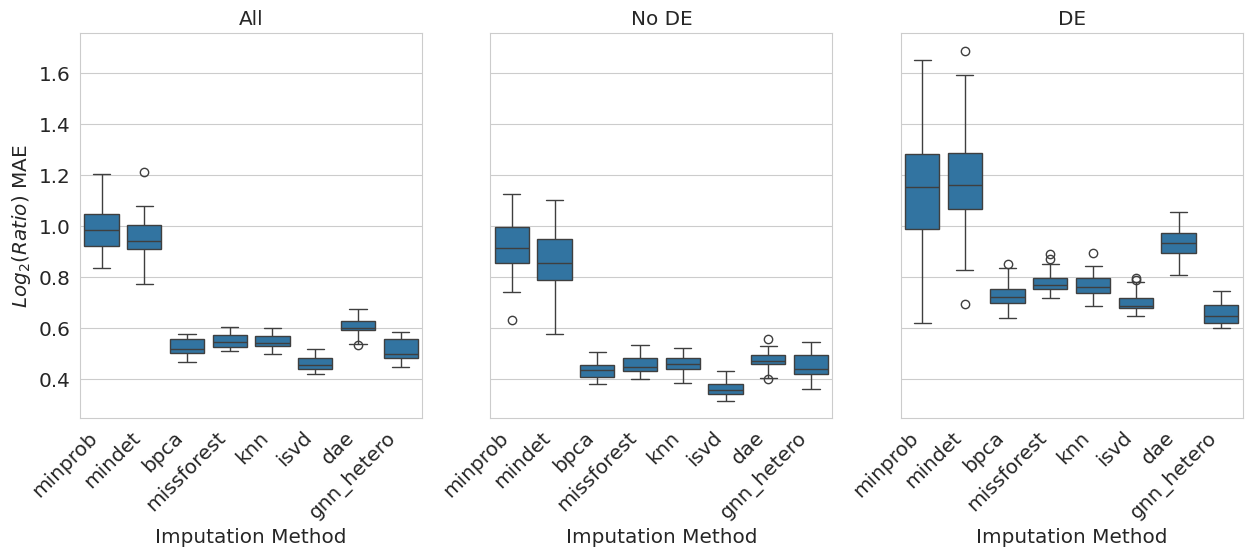

In [83]:
import math
from pyproteonet.metrics import calculate_ratio_absolute_error
from matplotlib import pyplot as plt

numerator_samples = [f'sample{s}' for s in (range(5,10))]
denominator_samples = [f'sample{s}' for s in (range(5))]
ground_truth_ratios = math.e**ds.wf('protein', 'abundance_gt')
ground_truth_ratios = ground_truth_ratios[numerator_samples].mean(axis=1) / ground_truth_ratios[denominator_samples].mean(axis=1)
ground_truth_ratios = ground_truth_ratios.groupby('id').mean()

ratio_mae = calculate_ratio_absolute_error(
            dataset=ds,
            numerator_samples=numerator_samples, denominator_samples=denominator_samples,
            molecule='protein',
            columns=imputation_methods + ['gnn_hetero'],
            ground_truth_ratios=ground_truth_ratios,
            calculate_log2_ratio=True,
            is_log=True,
        )
ratio_mae["gt"] = ground_truth_ratios.loc[
    ratio_mae.index.get_level_values("id")
].values
ratio_mae["gt"] = np.abs(np.log(ratio_mae["gt"])) >= np.log(2)
m = {False: "No DE", True: "DE"}
ratio_mae_subsets = {"All": ratio_mae}
for k, g in ratio_mae.groupby("gt"):
    ratio_mae_subsets[m[k]] = g
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
res_df = []
for i, (k, data) in enumerate(ratio_mae_subsets.items()):
    data = data.groupby(["nominator_sample", "denominator_sample"]).mean()
    del data["gt"]
    data = data.melt(
        value_vars=imputation_methods + ['gnn_hetero'], var_name="Imputation Method", value_name="MAE"
    )
    sns.boxplot(data=data, x="Imputation Method", y="MAE", ax=axs[i])
    axs[i].set_title(k)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha="right")
    axs[i].set_ylabel('$Log_2(Ratio)$ MAE')

Often differentially expressed molecules are found by statistical testing. Therefore, it is of interest which imputation method best allows correctly finding differentially expressed molecules from the imputed values. 
Given the ground truth ratios we can investigate this with reference to common metrics like precision, recall etc. using the ```evaluate_des``` function.

[Text(0, 0, 'minprob'),
 Text(1, 0, 'mindet'),
 Text(2, 0, 'bpca'),
 Text(3, 0, 'missforest'),
 Text(4, 0, 'knn'),
 Text(5, 0, 'isvd'),
 Text(6, 0, 'dae'),
 Text(7, 0, 'gnn_hetero')]

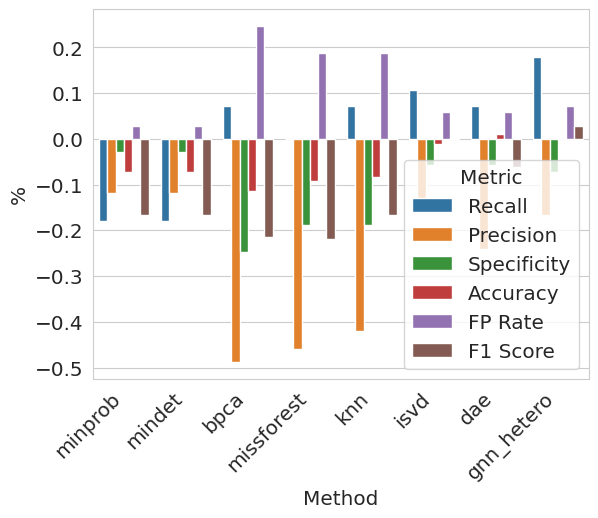

In [102]:
from pyproteonet.metrics import evaluate_des

res = evaluate_des(dataset=ds, molecule='protein', columns=imputation_methods + ['gnn_hetero', 'aggregated'], numerator_samples=numerator_samples,
                   denominator_samples=denominator_samples, gt_fc=ground_truth_ratios,
                   min_fc=2, max_pvalue=0.05, is_log=True, absolute_metrics=False)
res['Method'] = res.index
res.loc[:, ['Recall', 'Precision', 'Specificity', 'Accuracy', 'FP Rate', 'F1 Score']] = (res[['Recall', 'Precision', 'Specificity', 'Accuracy', 'FP Rate', 'F1 Score']] - res.loc['aggregated'])
res = res.drop(labels=['aggregated'])
de_res = res.melt(id_vars=['Method'], value_vars=['Recall', 'Precision', 'Specificity', 'Accuracy', 'FP Rate', 'F1 Score'], value_name='%', var_name='Metric')
ax = sns.barplot(data=de_res, x='Method', y='%', hue='Metric')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")